Requirements to run this notebook:

1. [Install `perfcapture` and its dependencies in a new virtual environment](https://github.com/zarr-developers/perfcapture).
2. Activate that venv.
3. Install additional Python dependencies within the venv: `pip install ipykernel zarr matplotlib`
4. Optionally, install `fio` to benchmark your local hard disk. (On Ubuntu: `sudo apt install fio`)

# Benchmark local hard disk using `fio`

[`fio`](https://fio.readthedocs.io/) is a disk benchmarking tool written by [Jens Axboe](https://en.wikipedia.org/wiki/Jens_Axboe) (Jens is the current Linux kernel maintainer of the block layer).





In [1]:
!mkdir -p ~/temp/fio

In [19]:
%%capture fio_json
!fio --name=read --size=1g --direct=1 --bs=128k --rw=read \
     --ioengine=io_uring --iodepth=32 \
     --directory="$HOME/temp/fio/" --output-format=json

In [20]:
import json
fio_json = json.loads(fio_json.stdout)
max_gbytes_per_sec = fio_json['jobs'][0]['read']['bw_bytes'] / 1E9
print(f"This hard drive is capable of {max_gbytes_per_sec:.3f} gigabytes per second.")

This hard drive is capable of 1.244 gigabytes per second.


# Analyse `results.csv`

In [21]:
import pandas as pd

In [22]:
results = pd.read_csv("results.csv")
results.head()

,workload,dataset,run_ID,Runtime in secs,GB/sec to numpy,read_count,write_count,read_merged_count,write_merged_count,read_IOPS,write_IOPS,avg read GB/sec,avg write GB/sec,read GB / read_time_secs,write GB / write_time_secs,read GB,write GB,read_time_secs,write_time_secs,busy_time_secs
0,NumpyLoadEntireArray,NumpyNPY,1,1.889592,0.529215,7712.0,6.0,0.0,2.0,4081.304324,3.175289,0.529218,0.000017,0.335572,0.006554,1.000006,0.000033,2.980,0.005,1.884
1,NumpyLoadEntireArray,NumpyNPY,2,1.919958,0.520845,7711.0,0.0,0.0,0.0,4016.233688,0.000000,0.520846,0.000000,0.326371,0.000000,1.000002,0.000000,3.064,0.000,1.924
2,NumpyLoadEntireArray,NumpyNPY,3,1.948534,0.513206,7711.0,0.0,0.0,0.0,3957.334078,0.000000,0.513207,0.000000,0.322685,0.000000,1.000002,0.000000,3.099,0.000,1.948
3,ZarrPythonLoadEntireArray,Uncompressed_1_Chunk,1,1.875216,0.533272,7631.0,2.0,0.0,0.0,4069.397872,1.066544,0.533275,0.000004,0.402255,0.000000,1.000006,0.000008,2.486,0.000,1.660
4,ZarrPythonLoadEntireArray,Uncompressed_1_Chunk,2,1.825329,0.547846,7631.0,0.0,0.0,0.0,4180.616207,0.000000,0.547850,0.000000,0.411018,0.000000,1.000006,0.000000,2.433,0.000,1.616


In [23]:
def get_result(column) -> pd.DataFrame:
    mean_result = results.groupby(["workload", "dataset"])[column].mean()
    return mean_result.to_frame().pivot_table(
        columns="workload",
        index="dataset"
    ).loc[[
        "NumpyNPY",
        "Uncompressed_1_Chunk",
        "Uncompressed_200_Chunks",
        "LZ4_200_Chunks",
        "Uncompressed_20000_Chunks",
        "LZ4_20000_Chunks"]
    ].droplevel(0, axis="columns")

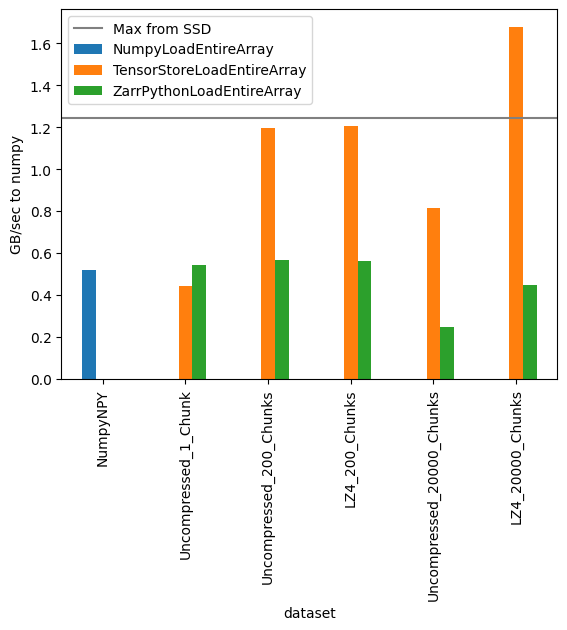

In [25]:
column_name = "GB/sec to numpy"
ax = get_result(column_name).plot.bar()
ax.set_ylabel(column_name)

# Draw "IO bandwidth" line
ax.plot(ax.get_xlim(), (max_gbytes_per_sec, max_gbytes_per_sec), color="gray", label="Max from SSD")
ax.legend();

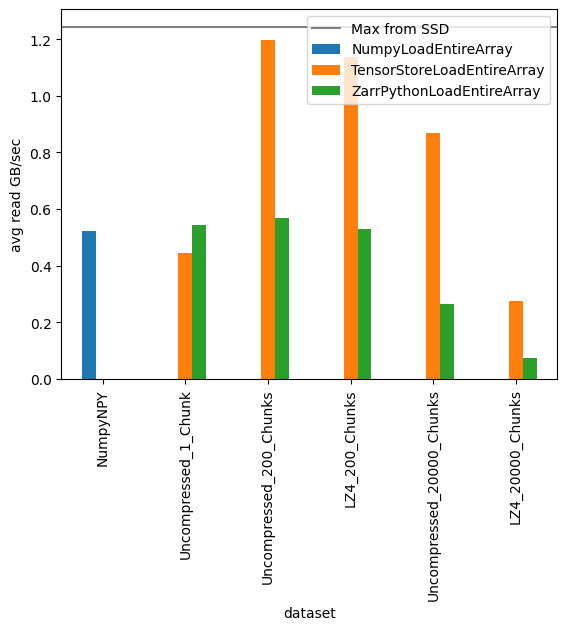

In [26]:
column_name = "avg read GB/sec"
ax = get_result(column_name).plot.bar()
ax.set_ylabel(column_name)

# Draw "IO bandwidth" line
ax.plot(ax.get_xlim(), (max_gbytes_per_sec, max_gbytes_per_sec), color="gray", label="Max from SSD")
ax.legend();

In [27]:
# TODO:
# Compute read GB / busy_time_secs
# Use fio with nrfiles and filesize to mimick reading 20,000 compressed chunks